In [4]:
%matplotlib inline
from SALib.sample import saltelli
from batchrunner import BatchRunnerMP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from model import BeeEvolutionModel
from agents import *
import pickle

## OFAT Sensitivity Analysis(Local Analysis)

In [2]:
problem = {
    'num_vars': 4,
    'names': ['alpha', 'forager_royal_ratio', 'growth_factor', 'resource_variability'],
    'bounds': [[0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0, 0.5]],
    'nominal_value': [0.5, 0.5, 0.5, 0.25]
}

# Set the repetitions, the amount of steps, and the amount of distinct values per variable
replicates = 20
distinct_samples = 20
seed = 20

# Set the outputs
model_reporters = {"Total Workers": lambda m: len([agent for agent in m.schedule_bees_and_flower_patches.agents if isinstance(agent, Worker)]),
                   "Total Queens": lambda m: len([agent for agent in m.schedule_bees_and_flower_patches.agents if isinstance(agent, Queen)]),
                   "Total Drones": lambda m: len([agent for agent in m.schedule_bees_and_flower_patches.agents if isinstance(agent, Drone)]),
                   "Total Fertilized Queens": lambda m: m.get_total_fertilized_queens()}

data = {}

for i, var in enumerate(problem['names']):

    # Get the bounds for this variable and get <distinct_samples> samples within this space (uniform)
    samples = np.linspace(*problem['bounds'][i], num=distinct_samples)
    
    fixed_parameters = {}
    for j, var_ in enumerate(problem['names']):
        if j != i:
            fixed_parameters[var_] = problem['nominal_value'][j]
    fixed_parameters["seed"] = seed
    
    variable_parameters=[{var: sample} for sample in samples]
    
    batch = BatchRunnerMP(BeeEvolutionModel, 
                        fixed_parameters=fixed_parameters,
                        iterations=replicates,
                        variable_parameters=variable_parameters,
                        model_reporters=model_reporters,
                        display_progress=True)
    
    batch.run_all()
    
    data[var] = batch.get_model_vars_dataframe()
    

BatchRunner MP will use 4 processors.


40it [16:34, 24.87s/it]


<AxesSubplot:xlabel='resource_variability', ylabel='Total Fertilized Queens'>

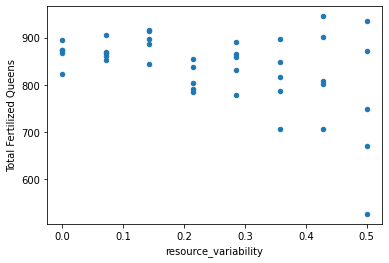

In [3]:
data['resource_variability'].plot.scatter(x='resource_variability', y='Total Fertilized Queens')

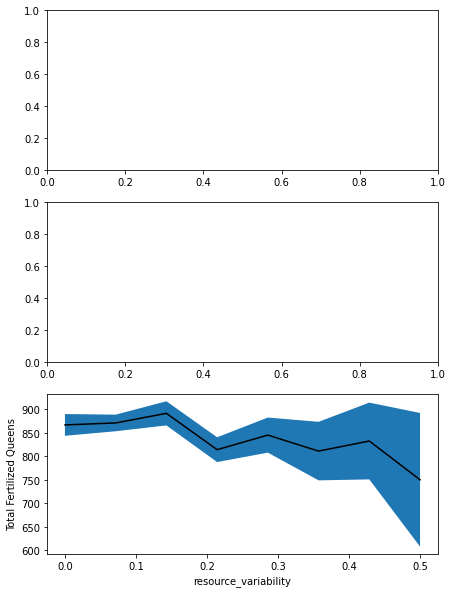

In [7]:
def plot_param_var_conf(ax, df, var, param, i):
    """
    Helper function for plot_all_vars. Plots the individual parameter vs
    variables passed.

    Args:
        ax: the axis to plot to
        df: dataframe that holds the data to be plotted
        var: variables to be taken from the dataframe
        param: which output variable to plot
    """
    x = df.groupby(var).mean().reset_index()[var]
    y = df.groupby(var).mean()[param]

    replicates = df.groupby(var)[param].count()
    err = (1.96 * df.groupby(var)[param].std()) / np.sqrt(replicates)

    ax.plot(x, y, c='k')
    ax.fill_between(x, y - err, y + err)

    ax.set_xlabel(var)
    ax.set_ylabel(param)

def plot_all_vars(df, param):
    """
    Plots the parameters passed vs each of the output variables.

    Args:
        df: dataframe that holds all data
        param: the parameter to be plotted
    """

    f, axs = plt.subplots(3, figsize=(7, 10))
    
    for i, var in enumerate(problem['names']):
        plot_param_var_conf(axs[i], data[var], var, param, i)

for param in ["Total Fertilized Queens"]:
    plot_all_vars(data, param)
    plt.savefig("results/sa_local.jpg", dpi="figure")
    plt.show()

In [ ]:
# how to load the data
# data is dictionary of dataframes

results = np.load('ofat_output.npz', allow_pickle=True)
data = results['data'][()]

In [106]:
ofat_results = np.load('./results/ofat_output.npz', allow_pickle=True)

data = ofat_results['data'][()]

In [107]:
data

{'alpha':         alpha  Run  Total Drones  Total Fertilized Queens  Total Queens  \
 0    0.000000  0.5            68                      820            83   
 272  0.684211  0.5            85                      875            88   
 271  0.684211  0.5            83                      855            98   
 270  0.684211  0.5           122                      839           118   
 269  0.684211  0.5           116                      893           103   
 ..        ...  ...           ...                      ...           ...   
 128  0.315789  0.5            90                      762           102   
 127  0.315789  0.5            85                      738           108   
 126  0.315789  0.5            95                      819            99   
 136  0.315789  0.5            95                      823           108   
 399  1.000000  0.5           108                      879           100   
 
      Total Workers  forager_royal_ratio  growth_factor  resource_variability

alpha
forager_royal_ratio
growth_factor
resource_variability


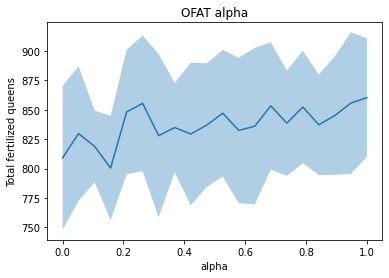

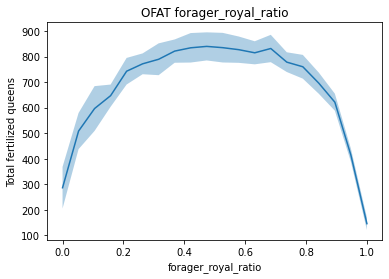

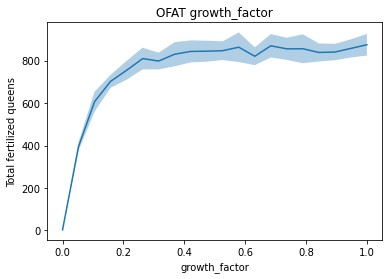

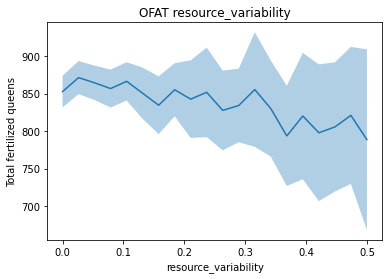

In [108]:
dict = {}
dict2 = {}
for i in data:
  dict[f'{i}'] = pd.DataFrame(data[f'{i}']).groupby(i, as_index=False)['Total Fertilized Queens']

for key, value in dict.items():
  dict2[f'{key}'] = pd.merge(value.mean().rename(columns={'Total Fertilized Queens':'Mean'}), value.std().rename(columns={'Total Fertilized Queens':'Std'}), how='right',on=key)

for key, value in  dict2.items():
  print(key)
  fig, ax = plt.subplots()
  ax.set(title=f"OFAT {key}", xlabel=f"{key}", ylabel="Total fertilized queens")
  ax.plot(dict2[f'{key}'][f'{key}'], dict2[f'{key}'].Mean)
  ax.fill_between(dict2[f'{key}'][f'{key}'], dict2[f'{key}'].Mean - dict2[f'{key}'].Std, dict2[f'{key}'].Mean + dict2[f'{key}'].Std, alpha=0.35)
  fig.savefig(f"OFAT {key}.pdf")